In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten,Input,LSTM,Embedding,Dropout,concatenate
from tensorflow.keras.regularizers import l2

from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder

from collections import Counter
from imblearn.over_sampling import SMOTE
from tqdm import trange
from time import sleep
from keras import regularizers

In [2]:
df = pd.read_csv(r'E:\bachelor project\datasets\8. normalized_2classes.csv')
df.shape

(910000, 38)

(910000, 38)


loop 1: 100%|██████████| 140/140 [00:00<00:00, 4010.73it/s]


test shape:  (65940, 4, 33) (65940,)


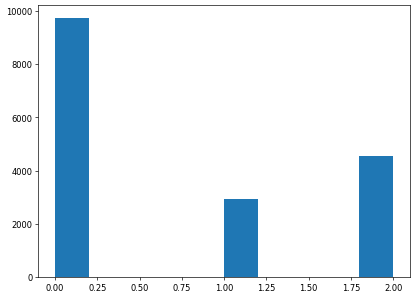

<Figure size 480x360 with 0 Axes>

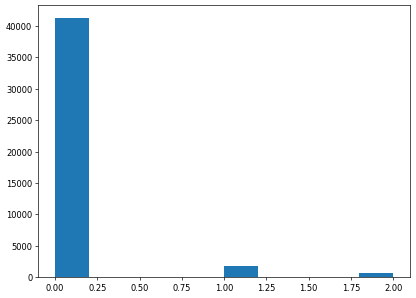

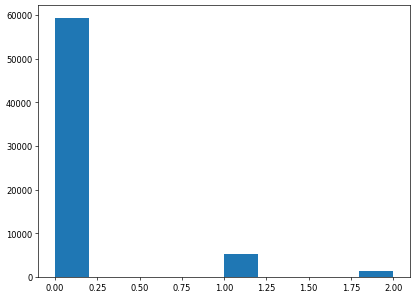

In [3]:
df = df.fillna(0)
print(df.shape)

#a little bit of preprocessing
df = df[df['time_index']>2019020000]
df = df[df['time_index']<=2019110000]
tedad=df["time_index"].nunique()
window_size = 4
#to put gamma to the last colomn
df['gamma_level2'] = df['gamma_quantile_y']
df.drop(['gamma_quantile_y'],axis=1,inplace=True)
df.drop(['gamma_value_y'],axis=1,inplace=True)
df.drop(['gamma_kmeans_y'],axis=1,inplace=True)
df.drop(['geohash'],axis=1,inplace=True)

conditions = [
    (df['gamma_level2'] ==0),
    (df['gamma_level2'] ==1),
    (df['gamma_level2'] ==2) 
    ]
values = [0,-1,-1]

zone_count = len(df["geohash_code"].unique())
gamma_index = df.columns.get_loc("gamma_level2")
geohash_index = df.columns.get_loc("geohash_code")

df.drop(['time_index'],axis=1,inplace=True)
j=0
k=tedad
df=df[['geohash_code', 'acc_count_y', 'Severity_y', 'duration_y', 'cng_count',
       'Cloudy', 'Fair', 'Fog',
       'Haze', 'Heavy Rain',
       'Light Rain', 'Mist',
       'Mostly Cloudy', 'Overcast',
       'Partly Cloudy', 'Smoke', 'weekend', 'Amenity', 'Bump', 'Crossing', 'Entrance',
       'Give_Way', 'Junction', 'Noexit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Circle',
       'Turning_Loop', 'gamma_level2']]

for i in range(1,zone_count+1):
    globals()['df%s' % i] = df[j:k]
    j=j+tedad
    k=k+tedad
    
#split data to train, test, validation
for i in range(1,zone_count+1):
    globals()['train%s' % i] = globals()['df%s' % i][:round(tedad*0.75)]
    globals()['valid%s' % i] = globals()['df%s' % i][round(tedad*0.75):round(tedad*0.85)]
    globals()['test%s' % i] = globals()['df%s' % i][round(tedad*0.85):]
    
## function for converting dataset into inputs and outputs
def split_sequences(sequences, n_steps):
    arr = df.to_numpy() 
    size = arr.shape[1]
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix,:size], sequences[end_ix, size-1]      
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

#converting each zone's records to inputs and outputs
for i in trange(1,zone_count+1):
    arr = globals()['train%s' % i].to_numpy() 
    globals()['x_train%s' % i] , globals()['y_train%s' % i] = split_sequences(arr, window_size)

    arr = globals()['valid%s' % i].to_numpy() 
    globals()['x_valid%s' % i] , globals()['y_valid%s' % i] = split_sequences(arr, window_size) 
    
    arr = globals()['test%s' % i].to_numpy() 
    globals()['x_test%s' % i] , globals()['y_test%s' % i] = split_sequences(arr, window_size) 
        
    
import random
random.seed(10)
for j in trange(1,zone_count+1,  desc ="loop 1"): 
    a = ((globals()['y_train%s' % j])==0)
    b = [not i for i in a]
    (globals()['y_train0_%s' % j]) = (globals()['y_train%s' % j])[a]
    (globals()['x_train0_%s' % j]) = (globals()['x_train%s' % j])[a]
    (globals()['y_train1_%s' % j]) = (globals()['y_train%s' % j])[b]
    (globals()['x_train1_%s' % j]) = (globals()['x_train%s' % j])[b]

for j in trange(1,zone_count+1,  desc ="loop 1"):
    a=np.array([random.random() for i in range((len(globals()['y_train0_%s' % j]))) ])
    a = (a>=0.97)
    (globals()['x_train0_%s' % j]) = (globals()['x_train0_%s' % j])[a]
    (globals()['y_train0_%s' % j]) = (globals()['y_train0_%s' % j])[a]
for k in trange(1,zone_count+1,  desc ="loop 1"): 
    globals()['x_train%s' % k] = np.concatenate((globals()['x_train0_%s' % k], globals()['x_train1_%s' % k]), axis=0)
    globals()['y_train%s' % k] = np.concatenate((globals()['y_train0_%s' % k], globals()['y_train1_%s' % k]), axis=0)

#validation
for j in trange(1,zone_count+1,  desc ="loop 1"): 
    a = ((globals()['y_valid%s' % j])==0)
    b = [not i for i in a]
    (globals()['y_valid0_%s' % j]) = (globals()['y_valid%s' % j])[a]
    (globals()['x_valid0_%s' % j]) = (globals()['x_valid%s' % j])[a]
    (globals()['y_valid1_%s' % j]) = (globals()['y_valid%s' % j])[b]
    (globals()['x_valid1_%s' % j]) = (globals()['x_valid%s' % j])[b]


    
#concatenating records of each zone and save it in x_train1,x_valid1,x_test1 and their y's

globals()['x_train%s' % 1000] = np.concatenate((globals()['x_train%s' % 1], globals()['x_train%s' % 2]), axis=0)
for k in range(3,zone_count+1):
    globals()['x_train%s' % 1000] = np.concatenate((globals()['x_train%s' % 1000], globals()['x_train%s' % k]), axis=0)

globals()['y_train%s' % 1000] = np.concatenate((globals()['y_train%s' % 1], globals()['y_train%s' % 2]), axis=0)
for k in range(3,zone_count+1):
    globals()['y_train%s' % 1000] = np.concatenate((globals()['y_train%s' % 1000], globals()['y_train%s' % k]), axis=0)

globals()['x_valid%s' % 1000] = np.concatenate((globals()['x_valid%s' % 1], globals()['x_valid%s' % 2]), axis=0)
for k in range(3,zone_count+1):
    globals()['x_valid%s' % 1000] = np.concatenate((globals()['x_valid%s' % 1000], globals()['x_valid%s' % k]), axis=0)

globals()['y_valid%s' % 1000] = np.concatenate((globals()['y_valid%s' % 1], globals()['y_valid%s' % 2]), axis=0)
for k in range(3,zone_count+1):
    globals()['y_valid%s' % 1000] = np.concatenate((globals()['y_valid%s' % 1000], globals()['y_valid%s' % k]), axis=0)
 
globals()['x_test%s' % 1000] = np.concatenate((globals()['x_test%s' % 1], globals()['x_test%s' % 2]), axis=0)    
for k in range(3,zone_count+1):
    globals()['x_test%s' % 1000] = np.concatenate((globals()['x_test%s' % 1000], globals()['x_test%s' % k]), axis=0)
    
globals()['y_test%s' % 1000] = np.concatenate((globals()['y_test%s' % 1], globals()['y_test%s' % 2]), axis=0)
for k in range(3,zone_count+1):
    globals()['y_test%s' % 1000] = np.concatenate((globals()['y_test%s' % 1000], globals()['y_test%s' % k]), axis=0)

    
print("test shape: ",x_test1000.shape,y_test1000.shape)

figure(figsize=(8, 6), dpi=60)
plt.hist(y_train1000)
plt.show()
figure(figsize=(8, 6), dpi=60)

figure(figsize=(8, 6), dpi=60)
plt.hist(y_valid1000)
plt.show()

figure(figsize=(8, 6), dpi=60)
plt.hist(y_test1000)
plt.show()

In [4]:
def LSTMM(new_x_train, new_y_train, new_x_test, new_y_test, new_x_valid, new_y_valid, 
          classweightt2, epoch, unit1, unit2, unit3, dense1, dense2):    
    from numpy.random import seed
    tf.random.set_seed(0)
    seed(10)
  
    dropout=0.2
    
    time_sensetive_inputs = Input(shape=(window_size,32))
    Xc_train = new_x_train.reshape(-1,window_size,33,1)
    Xc_valid = new_x_valid.reshape(-1,window_size,33,1)
    Xc_test = new_x_test.reshape(-1,window_size,33,1)

    e_inputs=Input(shape=(window_size,1))

    ######LSTM layers########
    l1 = LSTM(units = 12, return_sequences = True,kernel_regularizer=regularizers.l2(0),recurrent_regularizer = regularizers.l2(0),
                         dropout=dropout,recurrent_dropout=dropout,unroll = True)(time_sensetive_inputs)
    l2 = LSTM(units = 24, return_sequences = False,kernel_regularizer=regularizers.l2(0),recurrent_regularizer = regularizers.l2(0),
                        dropout=dropout,recurrent_dropout=dropout,unroll = True)(l1)
    
    #######Embedding layer##########
    em = Embedding(input_dim=zone_count+1, output_dim=20, embeddings_initializer='uniform',input_length=1, name='embedding')(e_inputs)
    d = Flatten()(em)
    d = Dense(50,activation='relu')(d)


    ###########Dense layers#############  
    level_3 = concatenate([d,l2])
    D = tf.keras.layers.BatchNormalization()(level_3)
    D = Dense(25, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=5e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-5))(level_3)
    r = tf.keras.layers.Dropout(0.2)(D) 
    D = Dense(25, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=5e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-5))(D)
    outputs = Dense(2,activation="softmax",name="last")(D)
    model1 = Model(inputs=[time_sensetive_inputs, e_inputs],outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=0.005)
    model1.compile(optimizer = opt, loss='sparse_categorical_crossentropy',metrics=["accuracy"])
    callback=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=40)

    history1 = model1.fit([new_x_train[:,:,1:],new_x_train[:,:,0]], new_y_train,batch_size=512 ,callbacks=[callback], epochs=150,validation_data=([new_x_valid[:,:,1:], new_x_valid[:,:,0]],new_y_valid),shuffle=False, verbose=0,class_weight=classweightt2)


    output2_train = model1.predict([new_x_train[:,:,1:],new_x_train[:,:,0]])
    output2_train = output2_train.argmax(axis=-1)
    output2 = model1.predict([new_x_test[:,:,1:],new_x_test[:,:,0]])
    output2 = output2.argmax(axis=-1)
   
    return output2_train, output2

In [5]:
def CNN(new_x_train, new_y_train, new_x_test, new_y_test, new_x_valid, new_y_valid, classweightt2, epoch, conv1, conv2, conv3):        
    
    cnn_model = Sequential()#add model layers
    cnn_model.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=(window_size,33,1)))
    
    Xc_train = new_x_train.reshape(-1,window_size,33,1)
    Xc_test = new_x_test.reshape(-1,window_size,33,1)

    cnn_model.add(Conv2D(64,padding="same", kernel_size=3, activation="relu"))
    cnn_model.add(Conv2D(64,padding="same", kernel_size=4, activation="relu"))
    cnn_model.add(Conv2D(128,padding="same", kernel_size=3, activation="relu"))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(40, activation="relu"))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Dense(20, activation="relu"))
#     cnn_model.add(Dense(3, activation="softmax"))
    cnn_model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy',metrics=["accuracy"])
    
    cnn_model.fit(Xc_train, new_y_train,batch_size=256 ,epochs=25,shuffle=False,class_weight=classweightt2, verbose=0)   
    
    
    output2_train = cnn_model.predict(Xc_train)
    output2_train = output2_train.argmax(axis=-1)
    output2 = cnn_model.predict(Xc_test)
    output2 = output2.argmax(axis=-1)
    
    return output2_train, output2

In [6]:
#بهش xوy میدی بهت نتیج مدل ابشاری رو برمیگردونه
def results(model1, model2, x_train100, y_train100, x_valid100, y_valid100, x_test100, y_test100, classweightt1, 
            classweightt2, epoch, unit1, unit2, unit3, dense1, dense2, conv1, conv2, conv3):
    print('model1 is: {} model2 is: {}'.format(str(model1), str(model2)))
    
    #Create zero and nonzero classes
    a=y_train100>0
    y_train_n=np.copy(y_train100)
    y_train_n[a]=1
    a=y_valid100>0
    y_valid_n=np.copy(y_valid100)
    y_valid_n[a]=1
    a=y_test100>0
    y_test_n=np.copy(y_test100)
    y_test_n[a]=1
    
    o1_train, o1= model1(x_train100, y_train_n, x_test100, y_test_n, x_valid100, y_valid_n, 
                         classweightt1, epoch, unit1, unit2, unit3, dense1, dense2) 
    g=o1>0
    conf_matrix=np.zeros((len(set(y_test100)),len(set(y_test100))))
    for i in range(len(o1)):
        if (o1[i]==0)and(y_test100[i]==0):
            conf_matrix[0,0]+=1     
        if (o1[i]==0)and(y_test100[i]==1):
            conf_matrix[1,0]+=1
        if (o1[i]==0)and(y_test100[i]==2):
            conf_matrix[2,0]+=1        
    
    t = o1_train>0
    new_y_trainn=y_train100[t]
    new_x_trainn=x_train100[t]
    tedad = new_x_trainn.shape[0]
    new_x_train=np.copy(new_x_trainn[: round(tedad*0.90)] )
    new_y_train=np.copy(new_y_trainn[: round(tedad*0.90)])
    new_x_valid=np.copy(new_x_trainn[round(tedad*0.90) :]  )
    new_y_valid=np.copy(new_y_trainn[round(tedad*0.90) :]  )
    new_x_test =np.copy(x_test100[g])
    new_y_test =np.copy(y_test100[g])
    
    print(new_x_train.shape)
    o2_train, o2 = model2(new_x_train, new_y_train,new_x_test, new_y_test, new_x_valid, new_y_valid, classweightt2, epoch, conv1, conv2, conv3)

    conf_matrix=confusion_matrix(new_y_test, o2, labels=[0,1,2]) + conf_matrix 
    # print("results for first model weights {} is: ".format(classweightt1))
    # print("results for second model weights {} is: ".format(classweightt2))
    f=0
    for i in range(len(conf_matrix)):
            if i ==0 :
                precision0.append(conf_matrix[i,i]/conf_matrix.sum(axis=0)[i])
                recall0.append(conf_matrix[i,i]/conf_matrix.sum(axis=1)[i])
                print("precision class {} is: {}".format(i,precision0[-1]))
                print("recall class {} is: {}".format(i,recall0[-1]))
                print("f1 score class {} is: {}".format(i,(2*recall0[-1]*precision0[-1])/(recall0[-1]+precision0[-1])))
                f+=conf_matrix.sum(axis=0)[i]*(2*recall0[-1]*precision0[-1])/(recall0[-1]+precision0[-1])
                print()
            if i ==1 :
                precision1.append(conf_matrix[i,i]/conf_matrix.sum(axis=0)[i])
                recall1.append(conf_matrix[i,i]/conf_matrix.sum(axis=1)[i])
                print("precision class {} is: {}".format(i,precision1[-1]))
                print("recall class {} is: {}".format(i,recall1[-1]))
                print("f1 score class {} is: {}".format(i,(2*recall1[-1]*precision1[-1])/(recall1[-1]+precision1[-1])))
                f+=conf_matrix.sum(axis=0)[i]*(2*recall1[-1]*precision1[-1])/(recall1[-1]+precision1[-1])
                print()
            if i ==2 :
                precision2.append(conf_matrix[i,i]/conf_matrix.sum(axis=0)[i])
                recall2.append(conf_matrix[i,i]/conf_matrix.sum(axis=1)[i])
                print("precision class {} is: {}".format(i,precision2[-1]))
                print("recall class {} is: {}".format(i,recall2[-1]))
                print("f1 score class {} is: {}".format(i,(2*recall2[-1]*precision2[-1])/(recall2[-1]+precision2[-1])))
                f+=conf_matrix.sum(axis=0)[i]*(2*recall2[-1]*precision2[-1])/(recall2[-1]+precision2[-1])
                print()

    f1.append(f/conf_matrix.sum()) 
    
    print("Weighted F1 score: ",f1[-1]) 
    print("Accuracy of model: ",(conf_matrix[0,0]+conf_matrix[1,1]+conf_matrix[2,2])/conf_matrix.sum())   

    print()
    print("-------------------------------------------------------------")
    return o2_train, new_y_train

In [7]:
#In order to create an excel colomns
precision0=[]
precision1=[]
precision2=[]
recall0=[]
recall1=[]
recall2=[]
f1=[]
acc=[]
models = []
weightss1 = []
weightss2 = []

# best model

In [8]:
o2, yyy = results(LSTMM, CNN, x_train1000, y_train1000, x_valid1000, y_valid1000, x_test1000, y_test1000, {0: 1,1: 3}, {0: 0.7, 1: 4.5, 2:2.5}, 150, 12, 24, -1, 25, 25, 64, 64, 128)

model1 is: <function LSTMM at 0x00000132858BFDC0> model2 is: <function CNN at 0x00000132B91CBDC0>
(13219, 4, 33)
precision class 0 is: 0.9587352625937835
recall class 0 is: 0.24153643635872685
f1 score class 0 is: 0.3858617993583349

precision class 1 is: 0.08715643200163482
recall class 1 is: 0.49315860474079787
f1 score class 1 is: 0.14813314037626626

precision class 2 is: 0.03029883146274999
recall class 2 is: 0.43820975283901137
f1 score class 2 is: 0.05667876274408156

Weighted F1 score:  0.17192347539552455
Accuracy of model:  0.2658022444646648

-------------------------------------------------------------


# window size tunning : It takes long time to run

In [46]:
  for u in range (3,11):
        window_size = u   

        #converting each zone's records to inputs and outputs
        for i in trange(1,zone_count+1):
            arr = globals()['train%s' % i].to_numpy() 
            globals()['x_train%s' % i] , globals()['y_train%s' % i] = split_sequences(arr, window_size)

            arr = globals()['valid%s' % i].to_numpy() 
            globals()['x_valid%s' % i] , globals()['y_valid%s' % i] = split_sequences(arr, window_size) 

            arr = globals()['test%s' % i].to_numpy() 
            globals()['x_test%s' % i] , globals()['y_test%s' % i] = split_sequences(arr, window_size) 


        import random
        random.seed(10)
        for j in trange(1,zone_count+1,  desc ="loop 1"): 
            a = ((globals()['y_train%s' % j])==0)
            b = [not i for i in a]
            (globals()['y_train0_%s' % j]) = (globals()['y_train%s' % j])[a]
            (globals()['x_train0_%s' % j]) = (globals()['x_train%s' % j])[a]
            (globals()['y_train1_%s' % j]) = (globals()['y_train%s' % j])[b]
            (globals()['x_train1_%s' % j]) = (globals()['x_train%s' % j])[b]

        for j in trange(1,zone_count+1,  desc ="loop 1"):
            a=np.array([random.random() for i in range((len(globals()['y_train0_%s' % j]))) ])
            a = (a>=0.97)
            (globals()['x_train0_%s' % j]) = (globals()['x_train0_%s' % j])[a]
            (globals()['y_train0_%s' % j]) = (globals()['y_train0_%s' % j])[a]
        for k in trange(1,zone_count+1,  desc ="loop 1"): 
            globals()['x_train%s' % k] = np.concatenate((globals()['x_train0_%s' % k], globals()['x_train1_%s' % k]), axis=0)
            globals()['y_train%s' % k] = np.concatenate((globals()['y_train0_%s' % k], globals()['y_train1_%s' % k]), axis=0)

        #validation
        for j in trange(1,zone_count+1,  desc ="loop 1"): 
            a = ((globals()['y_valid%s' % j])==0)
            b = [not i for i in a]
            (globals()['y_valid0_%s' % j]) = (globals()['y_valid%s' % j])[a]
            (globals()['x_valid0_%s' % j]) = (globals()['x_valid%s' % j])[a]
            (globals()['y_valid1_%s' % j]) = (globals()['y_valid%s' % j])[b]
            (globals()['x_valid1_%s' % j]) = (globals()['x_valid%s' % j])[b]



        #concatenating records of each zone and save it in x_train1,x_valid1,x_test1 and their y's

        globals()['x_train%s' % 1000] = np.concatenate((globals()['x_train%s' % 1], globals()['x_train%s' % 2]), axis=0)
        for k in range(3,zone_count+1):
                globals()['x_train%s' % 1000] = np.concatenate((globals()['x_train%s' % 1000], globals()['x_train%s' % k]), axis=0)

        globals()['y_train%s' % 1000] = np.concatenate((globals()['y_train%s' % 1], globals()['y_train%s' % 2]), axis=0)
        for k in range(3,zone_count+1):
            globals()['y_train%s' % 1000] = np.concatenate((globals()['y_train%s' % 1000], globals()['y_train%s' % k]), axis=0)

        globals()['x_valid%s' % 1000] = np.concatenate((globals()['x_valid%s' % 1], globals()['x_valid%s' % 2]), axis=0)
        for k in range(3,zone_count+1):
            globals()['x_valid%s' % 1000] = np.concatenate((globals()['x_valid%s' % 1000], globals()['x_valid%s' % k]), axis=0)

        globals()['y_valid%s' % 1000] = np.concatenate((globals()['y_valid%s' % 1], globals()['y_valid%s' % 2]), axis=0)
        for k in range(3,zone_count+1):
            globals()['y_valid%s' % 1000] = np.concatenate((globals()['y_valid%s' % 1000], globals()['y_valid%s' % k]), axis=0)


        # print("train shape: ",x_train100.shape,y_train100.shape)

        globals()['x_test%s' % 1000] = np.concatenate((globals()['x_test%s' % 1], globals()['x_test%s' % 2]), axis=0)    
        for k in range(3,zone_count+1):
            globals()['x_test%s' % 1000] = np.concatenate((globals()['x_test%s' % 1000], globals()['x_test%s' % k]), axis=0)

        globals()['y_test%s' % 1000] = np.concatenate((globals()['y_test%s' % 1], globals()['y_test%s' % 2]), axis=0)
        for k in range(3,zone_count+1):
            globals()['y_test%s' % 1000] = np.concatenate((globals()['y_test%s' % 1000], globals()['y_test%s' % k]), axis=0)


        print("test shape: ",x_test1000.shape,y_test1000.shape)

        o2, yyy = results(LSTMM, CNN, x_train1000, y_train1000, x_valid1000, y_valid1000, x_test1000, y_test1000, {0: 1,1: 3}, {0: 0.7, 1: 4.5, 2:2.5}, 150, 12, 24, -1, 25, 25, 64, 64, 128)

loop 1: 100%|██████████| 140/140 [00:00<00:00, 6380.97it/s]


test shape:  (66080, 3, 33) (66080,)
model1 is: <function LSTMM at 0x000001EA771AC160> model2 is: <function CNN at 0x000001EA771AC280>
(12850, 3, 33)


  1%|          | 1/140 [00:00<00:22,  6.27it/s]

precision class 0 is: 0.9577298952078181
recall class 0 is: 0.27392278031285255
f1 score class 0 is: 0.4260032733224222

precision class 1 is: 0.09199745951095586
recall class 1 is: 0.5579738058551618
f1 score class 1 is: 0.15795212910964507

precision class 2 is: 0.02908429902294933
recall class 2 is: 0.34156104069379584
f1 score class 2 is: 0.053604145945662984

Weighted F1 score:  0.1990564699083662
Accuracy of model:  0.29777542372881355

-------------------------------------------------------------


loop 1: 100%|██████████| 140/140 [00:00<00:00, 4840.83it/s]


test shape:  (65940, 4, 33) (65940,)
model1 is: <function LSTMM at 0x000001EA771AC160> model2 is: <function CNN at 0x000001EA771AC280>
(13219, 4, 33)


  1%|          | 1/140 [00:00<00:20,  6.68it/s]

precision class 0 is: 0.9587352625937835
recall class 0 is: 0.24153643635872685
f1 score class 0 is: 0.3858617993583349

precision class 1 is: 0.08715643200163482
recall class 1 is: 0.49315860474079787
f1 score class 1 is: 0.14813314037626626

precision class 2 is: 0.03029883146274999
recall class 2 is: 0.43820975283901137
f1 score class 2 is: 0.05667876274408156

Weighted F1 score:  0.17192347539552455
Accuracy of model:  0.2658022444646648

-------------------------------------------------------------


loop 1: 100%|██████████| 140/140 [00:00<00:00, 3190.33it/s]


test shape:  (65800, 5, 33) (65800,)
model1 is: <function LSTMM at 0x000001EA771AC160> model2 is: <function CNN at 0x000001EA771AC280>
(13266, 5, 33)


  1%|          | 1/140 [00:00<00:16,  8.40it/s]

precision class 0 is: 0.9594770347046341
recall class 0 is: 0.23707800554766253
f1 score class 0 is: 0.38020967545061235

precision class 1 is: 0.09481758986709482
recall class 1 is: 0.6153994596680818
f1 score class 1 is: 0.16431791833054232

precision class 2 is: 0.027622736074723774
recall class 2 is: 0.3246318607764391
f1 score class 2 is: 0.05091328994331304

Weighted F1 score:  0.18198971490416133
Accuracy of model:  0.26886018237082066

-------------------------------------------------------------


loop 1: 100%|██████████| 140/140 [00:00<00:00, 4821.43it/s]


test shape:  (65660, 6, 33) (65660,)
model1 is: <function LSTMM at 0x000001EA771AC160> model2 is: <function CNN at 0x000001EA771AC280>
(13455, 6, 33)


  1%|          | 1/140 [00:00<00:15,  9.05it/s]

precision class 0 is: 0.9595223325062034
recall class 0 is: 0.20973947827855655
f1 score class 0 is: 0.34423379188516273

precision class 1 is: 0.08349115801483172
recall class 1 is: 0.7076000773544769
f1 score class 1 is: 0.14935913135766185

precision class 2 is: 0.039937353171495694
recall class 2 is: 0.23927613941018766
f1 score class 2 is: 0.06844981305723324

Weighted F1 score:  0.17661857738073708
Accuracy of model:  0.24961925068534876

-------------------------------------------------------------


loop 1: 100%|██████████| 140/140 [00:00<00:00, 6020.00it/s]


test shape:  (65520, 7, 33) (65520,)
model1 is: <function LSTMM at 0x000001EA771AC160> model2 is: <function CNN at 0x000001EA771AC280>
(13015, 7, 33)


  1%|          | 1/140 [00:00<00:21,  6.53it/s]

precision class 0 is: 0.9579153946794592
recall class 0 is: 0.22388135765976966
f1 score class 0 is: 0.3629378717779247

precision class 1 is: 0.08469100732447712
recall class 1 is: 0.5887705711519845
f1 score class 1 is: 0.14808141799766267

precision class 2 is: 0.032040365815200256
recall class 2 is: 0.34116856950973806
f1 score class 2 is: 0.058579335793357945

Weighted F1 score:  0.17153898176078222
Accuracy of model:  0.2553113553113553

-------------------------------------------------------------


loop 1: 100%|██████████| 140/140 [00:00<00:00, 2967.09it/s]


test shape:  (65380, 8, 33) (65380,)
model1 is: <function LSTMM at 0x000001EA771AC160> model2 is: <function CNN at 0x000001EA771AC280>
(12605, 8, 33)


  1%|          | 1/140 [00:00<00:21,  6.39it/s]

precision class 0 is: 0.9554845858046015
recall class 0 is: 0.2495701469161233
f1 score class 0 is: 0.39576696722639165

precision class 1 is: 0.08840108562736736
recall class 1 is: 0.5753105590062112
f1 score class 1 is: 0.15325353532742175

precision class 2 is: 0.031075842015992245
recall class 2 is: 0.3449899125756557
f1 score class 2 is: 0.057015837732703537

Weighted F1 score:  0.18586582767572837
Accuracy of model:  0.2774089935760171

-------------------------------------------------------------


loop 1: 100%|██████████| 140/140 [00:00<00:00, 2054.99it/s]


test shape:  (65240, 9, 33) (65240,)
model1 is: <function LSTMM at 0x000001EA771AC160> model2 is: <function CNN at 0x000001EA771AC280>
(11638, 9, 33)


  1%|          | 1/140 [00:00<00:17,  7.89it/s]

precision class 0 is: 0.9536347160692711
recall class 0 is: 0.3231821749070188
f1 score class 0 is: 0.4827594994775606

precision class 1 is: 0.09173222502597596
recall class 1 is: 0.6006998444790047
f1 score class 1 is: 0.1591593911766978

precision class 2 is: 0.03635274997861603
recall class 2 is: 0.286774628879892
f1 score class 2 is: 0.06452592423897366

Weighted F1 score:  0.24072948144830122
Accuracy of model:  0.34423666462293073

-------------------------------------------------------------


loop 1: 100%|██████████| 140/140 [00:00<00:00, 1754.84it/s]


test shape:  (65100, 10, 33) (65100,)
model1 is: <function LSTMM at 0x000001EA771AC160> model2 is: <function CNN at 0x000001EA771AC280>
(12731, 10, 33)
precision class 0 is: 0.9581765738650615
recall class 0 is: 0.26126280155242865
f1 score class 0 is: 0.4105753858967986

precision class 1 is: 0.08885429279824714
recall class 1 is: 0.6003116478379431
f1 score class 1 is: 0.15479658463083878

precision class 2 is: 0.03248997649661275
recall class 2 is: 0.3182125930941097
f1 score class 2 is: 0.05896004516088566

Weighted F1 score:  0.19616047007810736
Accuracy of model:  0.28929339477726573

-------------------------------------------------------------


# best model

In [42]:
for i in range(6):
    o2, yyy = results(LSTMM, CNN, x_train1000, y_train1000, x_valid1000, y_valid1000, x_test1000, y_test1000, {0: 1,1: 3}, {0: 0.7, 1: 4.5, 2:2.5}, 150, 12, 24, -1, 25, 25, 64, 64, 128)

model1 is: <function LSTMM at 0x000001909A7F8820> model2 is: <function CNN at 0x000001909A7F8CA0>
(13348, 4, 33)
precision class 0 is: 0.9579979709164694
recall class 0 is: 0.23903871468592838
f1 score class 0 is: 0.3826091654398358

precision class 1 is: 0.08262903986361493
recall class 1 is: 0.439005588745423
f1 score class 1 is: 0.1390805299468832

precision class 2 is: 0.031247350122954296
recall class 2 is: 0.4923179692718771
f1 score class 2 is: 0.058764900530239604

Weighted F1 score:  0.16495627214194458
Accuracy of model:  0.2605247194419169

-------------------------------------------------------------
model1 is: <function LSTMM at 0x000001909A7F8820> model2 is: <function CNN at 0x000001909A7F8CA0>
(12963, 4, 33)
precision class 0 is: 0.9580500949231429
recall class 0 is: 0.264015931413913
f1 score class 0 is: 0.41395551909820993

precision class 1 is: 0.09358215293911915
recall class 1 is: 0.7219117363653883
f1 score class 1 is: 0.16568623114688844

precision class 2 is: 0.0

# base models

# LSTM

In [20]:
for u in range(0,5):
    dropout=0.020
    #LSTM model
    np.random.seed(7)
    window_size=4
    inputs=Input(shape=(window_size,32))
    e_inputs=Input(shape=(window_size,1))
    Learning_rate=0.0035
    ######LSTM layers########
    l1=LSTM(units = 35, return_sequences = True,kernel_regularizer=regularizers.l2(0),recurrent_regularizer = regularizers.l2(0),
                         dropout=dropout,recurrent_dropout=dropout,unroll = True)(inputs)
    l2=LSTM(units = 50, return_sequences = True,kernel_regularizer=regularizers.l2(0),recurrent_regularizer = regularizers.l2(0),
                         dropout=dropout,recurrent_dropout=dropout,unroll = True)(l1)
    l3=LSTM(units = 30, return_sequences = False,
                         kernel_regularizer=regularizers.l2(0),recurrent_regularizer = regularizers.l2(0),
                         dropout=dropout,recurrent_dropout=dropout,unroll = True)(l2)
    #######Embedding layer##########
    em=Embedding(input_dim=zone_count+1, output_dim=20, embeddings_initializer='uniform',input_length=1, name='embedding')(e_inputs)
    d=Flatten()(em)
    d=Dense(50,activation='relu')(d)
    level_3 = concatenate([d,l3])
    ###########Dense layers#############                      
    d1=Dense(50,activation='relu')(level_3)
    d2=Dense(40,activation='relu')(d1)
    d3=Dense(40,activation='relu')(d2)
    d4=Dense(20,activation='relu')(d3)
    outputs=Dense(3,activation="softmax")(d4)

    model=Model(inputs=[inputs, e_inputs],outputs=outputs)
    # l3_model = Model(inputs,l3)
    # d2_model = Model(inputs,d2)
    # d4_model = Model(inputs,d4)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0004)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=["accuracy"])
    callback=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=30)

    # history=model.fit([x_train100[:,:,0:35], x_train100[:,:,35:]], y_train100,batch_size=512 ,callbacks=[callback],epochs=30,validation_split=0.20,shuffle=True, verbose=1)
    history=model.fit([x_train1000[:,:,1:], x_train1000[:,:,0]], y_train1000,batch_size=512 ,callbacks=[callback],epochs=150,
                      validation_data=([x_valid1000[:,:,1:], x_valid1000[:,:,0]],y_valid1000),shuffle=True, verbose=0,
                      class_weight={0 : 1, 1:2.7, 2:2})
    # print("train accuracy: ",model.evaluate([x_train100[:,:,1:], x_train100[:,:,0]],y_train100)[1])
    # print("test accuracy: ",model.evaluate([x_test100[:,:,1:], x_test100[:,:,0]],y_test100)[1])

    #Confusion Matrix
    y_prob = model.predict([x_test1000[:,:,1:], x_test1000[:,:,0]])
    predictions = y_prob.argmax(axis=-1)

    print("Confusion Matrix:")
    print(confusion_matrix(y_test1000, predictions, labels=[0,1,2]))
    print("Classification Report")
    print(classification_report(y_test1000, predictions))

Confusion Matrix:
[[35313 13487 10454]
 [ 1849  1481  1859]
 [  539   389   569]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.94      0.60      0.73     59254
         1.0       0.10      0.29      0.14      5189
         2.0       0.04      0.38      0.08      1497

    accuracy                           0.57     65940
   macro avg       0.36      0.42      0.32     65940
weighted avg       0.85      0.57      0.67     65940

Confusion Matrix:
[[35141 13902 10211]
 [ 1831  1756  1602]
 [  526   495   476]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.94      0.59      0.73     59254
         1.0       0.11      0.34      0.16      5189
         2.0       0.04      0.32      0.07      1497

    accuracy                           0.57     65940
   macro avg       0.36      0.42      0.32     65940
weighted avg       0.85      0.57      0.67     65940

Confusion Matrix:
[[32346 1463

# Base Models

# CNN 

In [18]:
for u in range(0,5):      
    #create model
    window_size=4
    cnn_model = Sequential()#add model layers
    cnn_model.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=(window_size,33,1)))

    Xc_train = x_train1000.reshape(-1,window_size,33,1)
    Xc_test = x_test1000.reshape(-1,window_size,33,1)

    cnn_model.add(Conv2D(64,padding="same", kernel_size=3, activation="relu"))
    cnn_model.add(Conv2D(64,padding="same", kernel_size=4, activation="relu"))
    cnn_model.add(Conv2D(128,padding="same", kernel_size=3, activation="relu"))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(40, activation="relu"))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Dense(20, activation="relu"))
    cnn_model.add(Dense(3, activation="softmax"))
    cnn_model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy',metrics=["accuracy"])

    cnn_model.fit(Xc_train, y_train1000,batch_size=256 ,epochs=25,shuffle=False,class_weight={0 : 1, 1:2.7, 2:2}, verbose=0)   

    output2_train = cnn_model.predict(Xc_train)
    output2_train = output2_train.argmax(axis=-1)
    output2 = cnn_model.predict(Xc_test)
    output2 = output2.argmax(axis=-1)

    print("Confusion Matrix:")
    print(confusion_matrix(y_test1000, output2 , labels=[0,1,2]))
    predictions = gb.predict(x_test1001)
    print(classification_report(y_test1000, output2 ))

Confusion Matrix:
[[40049  9723  9482]
 [ 2167  1509  1513]
 [  638   404   455]]
              precision    recall  f1-score   support

         0.0       0.93      0.68      0.78     59254
         1.0       0.13      0.29      0.18      5189
         2.0       0.04      0.30      0.07      1497

    accuracy                           0.64     65940
   macro avg       0.37      0.42      0.34     65940
weighted avg       0.85      0.64      0.72     65940

Confusion Matrix:
[[37050  8745 13459]
 [ 1860  1453  1876]
 [  525   417   555]]
              precision    recall  f1-score   support

         0.0       0.94      0.63      0.75     59254
         1.0       0.14      0.28      0.18      5189
         2.0       0.03      0.37      0.06      1497

    accuracy                           0.59     65940
   macro avg       0.37      0.43      0.33     65940
weighted avg       0.86      0.59      0.69     65940

Confusion Matrix:
[[35775 14670  8809]
 [ 1850  2137  1202]
 [  563   589 

# RF

In [15]:
x_train1001 = x_train1000.reshape(x_train1000.shape[0],-1)
x_test1001 = x_test1000.reshape(x_test1000.shape[0],-1)
x_valid1001 = x_valid1000.reshape(x_valid1000.shape[0],-1)

for u in range(0,5):
    rf = RandomForestClassifier(n_estimators = 200, max_depth= 12, random_state=0, min_samples_split =2, 
                                class_weight = {0 : 1, 1:3, 2:1.5} )
    rf = rf.fit(x_train1001, y_train1000)
    rf.score(x_train1001, y_train1000)

    predictions =rf.predict(x_test1001)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test1000, predictions, labels=[0,1,2]))
    predictions = rf.predict(x_test1001)
    print(classification_report(y_test1000, predictions))
    #  1 3 1.5

Confusion Matrix:
[[41457 10131  7666]
 [ 2284  1591  1314]
 [  708   375   414]]
              precision    recall  f1-score   support

         0.0       0.93      0.70      0.80     59254
         1.0       0.13      0.31      0.18      5189
         2.0       0.04      0.28      0.08      1497

    accuracy                           0.66     65940
   macro avg       0.37      0.43      0.35     65940
weighted avg       0.85      0.66      0.73     65940

Confusion Matrix:
[[41457 10131  7666]
 [ 2284  1591  1314]
 [  708   375   414]]
              precision    recall  f1-score   support

         0.0       0.93      0.70      0.80     59254
         1.0       0.13      0.31      0.18      5189
         2.0       0.04      0.28      0.08      1497

    accuracy                           0.66     65940
   macro avg       0.37      0.43      0.35     65940
weighted avg       0.85      0.66      0.73     65940

Confusion Matrix:
[[41457 10131  7666]
 [ 2284  1591  1314]
 [  708   375 

# Geadient Boosting

In [16]:
for u in range(0,5):    
    x_train1001 = x_train1000.reshape(x_train1000.shape[0],-1)
    x_test1001 = x_test1000.reshape(x_test1000.shape[0],-1)
    x_valid1001 = x_valid1000.reshape(x_valid1000.shape[0],-1)

    gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.8,
          max_depth=2, random_state=0, subsample = 0.4 )         # subsample = 0.8
    gb = gb.fit(x_train1001, y_train1000)
    gb.score(x_train1001, y_train1000)
    predictions = gb.predict(x_test1001)

    print("Confusion Matrix:")
    print(confusion_matrix(y_test1000, predictions, labels=[0,1,2]))
    predictions = gb.predict(x_test1001)
    print(classification_report(y_test1000, predictions))

Confusion Matrix:
[[47826  5306  6122]
 [ 3246   853  1090]
 [  968   195   334]]
              precision    recall  f1-score   support

         0.0       0.92      0.81      0.86     59254
         1.0       0.13      0.16      0.15      5189
         2.0       0.04      0.22      0.07      1497

    accuracy                           0.74     65940
   macro avg       0.37      0.40      0.36     65940
weighted avg       0.84      0.74      0.79     65940

Confusion Matrix:
[[47826  5306  6122]
 [ 3246   853  1090]
 [  968   195   334]]
              precision    recall  f1-score   support

         0.0       0.92      0.81      0.86     59254
         1.0       0.13      0.16      0.15      5189
         2.0       0.04      0.22      0.07      1497

    accuracy                           0.74     65940
   macro avg       0.37      0.40      0.36     65940
weighted avg       0.84      0.74      0.79     65940

Confusion Matrix:
[[47826  5306  6122]
 [ 3246   853  1090]
 [  968   195 